/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/gianni/anaconda/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


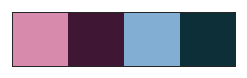

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts
import seaborn as sns
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy.signal import convolve2d
from statsmodels.formula.api import ols

from lib.utility_functions import *
from lib.exp4 import *

sns.set_style('white')
sns.set_context('paper')

colors = sns.color_palette().as_hex()

pd.set_option('display.max_columns', 40)

% matplotlib inline

colors = sns.cubehelix_palette(n_colors=2, start=0.5, hue=1, rot=.1, light=.65) 
colors += sns.cubehelix_palette(n_colors=2, start=2.5, hue=1, rot=.1, light=.65)
sns.palplot(colors)

In [2]:
tidy = pd.read_csv('./tidy_data.csv', index_col=0)
tidy['Condition'] = tidy['Condition'].map(lambda x: 'Untrained' if x == 'Naive' else x)
tidy['Position ID'] = tidy['Position ID'].map(int)

In [3]:
vals = ['Black Position', 'White Position', 'Is Real']

board_set = tidy.pivot_table(
    index='Position ID', values=vals,
    aggfunc=lambda x: x.unique()[0]
)[vals]

board_set.head()

,Black Position,White Position,Is Real
Position ID,,,
0,000000000010000000001000010100011000,000000000000101000010001000000100000,False
1,000101100000000000001010000000000100,000010010000010000010000000001000000,False
2,000000000000110000000011100000100000,000110010001000000000000000000000100,False
3,010010100000110000000000010000000000,000000000110000000000010000000101000,False
4,001100000000100100000001000000010000,000010000000000000010110000010000000,False


In [4]:
def position_string_to_array(position_string):
    return np.stack(list(position_string)).astype(int).reshape([4, 9])

count_filter = np.ones((3, 3), dtype=int)
count_filter[1, 1] = 0
dummy = convolve2d(np.ones((4, 9)), count_filter, mode='same')

def count_neighbors(position_array):
    counts = convolve2d(position_array, count_filter, mode='same')
    return counts / dummy

def get_adjacency(row, 
                  bp_name='Black Position', 
                  wp_name='White Position'):
    
    bp_string = row[bp_name]
    wp_string = row[wp_name]
    
    bp = position_string_to_array(bp_string)
    wp = position_string_to_array(wp_string)
    
    p = bp + wp
    
    # Average fraction of neighbors at all locations
    t = count_neighbors(p)
    
    # Average fraction of neighbors at occupied locations
    ct = count_neighbors(p) * p
    
    # Average fraction of same-color neighbors at occupied locations
    cs = count_neighbors(bp) * bp + count_neighbors(wp) * wp # is this right?
    
    # Average fraction of opposite color neighbors at occupied locations
    co = count_neighbors(bp) * wp + count_neighbors(wp) * bp
    
    results = {
        'Total': t.mean(),
        'Cond. Total': ct[ct > 0].mean() if (ct > 0).any() else 0,
        'Same': cs[cs > 0].mean(),
        'Opposite': co[co > 0].mean()
    }
    
    return pd.Series(results)
    
adjacencies = board_set.apply(get_adjacency, axis=1)

In [5]:
def get_adjacency_per_location(row,
                               bp_name='Black Position',
                               wp_name='White Position'):
    bp_string = row[bp_name]
    wp_string = row[wp_name]
    
    bp = position_string_to_array(bp_string)
    wp = position_string_to_array(wp_string)
    
    p = bp + wp
    
    t = count_neighbors(p)
    
    return t.reshape(36)

def get_errors_per_location(row,
                            bp_name='Black Position',
                            wp_name='White Position'):
    bp_string = row[bp_name]
    wp_string = row[wp_name]
    bp_string_final = row[bp_name + ' (final)']
    wp_string_final = row[wp_name + ' (final)']
    
    error = [
        0 if (bi == bf) & (wi == wf) else 1
        for bi, wi, bf, wf in zip(bp_string, wp_string, bp_string_final, wp_string_final)
    ]
    
    return error


adjacencies_by_location = board_set.apply(get_adjacency_per_location, axis=1)
errors_by_location = tidy.apply(get_errors_per_location, axis=1)

In [6]:
tidy_adjacencies = tidy.apply(
    lambda x: get_adjacency(x, bp_name='Black Position (final)', wp_name='White Position (final)'),
    axis=1
)

/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:40: RuntimeWarning: Mean of empty slice.
/Users/gianni/anaconda/lib/python3.5/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/gianni/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:39: RuntimeWarning: Mean of empty slice.


In [7]:
board_set = pd.concat([board_set, adjacencies], axis=1)

In [8]:
tidy['Cond. Total Adj (final)'] = tidy_adjacencies['Cond. Total']
tidy['Total Adj (final)'] = tidy_adjacencies['Total']

tidy['Cond. Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Cond. Total'])
tidy['Total Adj'] = tidy['Position ID'].map(lambda x: board_set.loc[x, 'Total'])

In [12]:
c = tidy['Condition'] == 'Trained'
r = tidy['Is Real'] == True
tidy.head()

,Subject ID,Condition,Game Index,Position ID,Is Real,Black Position,White Position,Black Position (final),White Position (final),Response Time,Num Black Pieces,Num White Pieces,Num Pieces,Total Black Errors,Total White Errors,Total Errors,Type I Errors (black),Type I Errors (white),Type I Errors,Type II Errors (black),Type II Errors (white),Type II Errors,Type III Errors (black),Type III Errors (white),Type III Errors,Num Pieces (final),Numerosity Error,Cond. Total Adj (final),Total Adj (final),Cond. Total Adj,Total Adj
0,1464109333721,Trained,0,25,False,000000000011010000010100000001010001,001100000000001000001000000010100010,000000000011010000010100100001000000,000100000000100010001011000000000100,43.957,8,7,15,3,10,13.0,1,5,6,2,5,7,0,0,0,14,1,0.542857,0.462500,0.568889,0.430787
2,1464109333721,Trained,1,92,True,001011000000011000000101000000010100,000100000001100100000010100001101000,000001000001011000000101000000010100,000100000000100100001010100000101000,36.897,9,9,18,3,3,5.0,0,1,1,2,1,3,0,1,1,16,2,0.748438,0.469444,0.802778,0.500000
4,1464109333721,Trained,2,16,False,100100000001010000000100000000101000,000010000010000100001001000001000000,100100000001010000000101000000100000,000001000010000100001000000000000000,17.922,7,6,13,2,4,5.0,0,1,1,1,2,3,0,1,1,11,2,0.400758,0.325231,0.450641,0.368287
6,1464109333721,Trained,3,75,True,000001001000101100001001000000010000,000100000001010000010110000000001000,000001001001001100000101000000010000,000100000000110000000010000000001000,22.380,8,7,15,4,4,5.0,0,0,0,1,1,2,1,2,3,13,2,0.643750,0.372917,0.641071,0.448843
8,1464109333721,Trained,4,69,True,000101000101100000001100000000000000,000000000010011000000001000000111000,000101000101100000001100000000000000,000000000010011000000001000000111000,20.494,7,7,14,0,0,0.0,0,0,0,0,0,0,0,0,0,14,0,0.544643,0.415046,0.544643,0.415046


In [33]:
tidy['condition'] = tidy['Condition']
tidy['isreal'] = tidy['Is Real']
tidy['subjid'] = tidy['Subject ID']
tidy['numerrs'] = tidy['Total Errors']
tidy['neighborhood_size'] = tidy['Cond. Total Adj']
tidy['num_pieces'] = tidy['Num Pieces']

formula = 'numerrs ~ num_pieces'
model = smf.glm(formula=formula, data=tidy, family=sm.families.NegativeBinomial(), groups=tidy['Subject ID'])
results = model.fit(method='bfgs', maxiters=10000)


In [34]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                numerrs   No. Observations:                 3648
Model:                            GLM   Df Residuals:                     3646
Model Family:        NegativeBinomial   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          bfgs   Log-Likelihood:                -10397.
Date:                Thu, 02 Aug 2018   Deviance:                       2140.7
Time:                        16:05:35   Pearson chi2:                 1.35e+03
No. Iterations:                     0   Covariance Type:             nonrobust
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2243      0.119     -1.889      0.059      -0.457       0.008
num_pieces     0.1372      0.008     17.072      0.000       0.121       0.153
==============================================================================
"""

In [53]:
nbdist = sm.NegativeBinomial(tidy['numerrs'], np.ones_like(tidy['numerrs']), )
nbresult = nbdist.fit()

nbresult.summary()

Optimization terminated successfully.
         Current function value: 2.792935
         Iterations: 5
         Function evaluations: 6
         Gradient evaluations: 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                numerrs   No. Observations:                 3648
Model:               NegativeBinomial   Df Residuals:                     3647
Method:                           MLE   Df Model:                            0
Date:                Thu, 02 Aug 2018   Pseudo R-squ.:              -2.060e-12
Time:                        16:25:04   Log-Likelihood:                -10189.
converged:                       True   LL-Null:                       -10189.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8125      0.012    146.807      0.000       1.788       1.837
alpha          0.3928      0.014     27.115      0.000       0.364       0.421
==============================================================================
"""

In [54]:
poissdist = sm.Poisson(tidy['numerrs'], np.ones_like(tidy['numerrs']), )
poissresult = poissdist.fit()

poissresult.summary()

Optimization terminated successfully.
         Current function value: 3.220573
         Iterations 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                numerrs   No. Observations:                 3648
Model:                        Poisson   Df Residuals:                     3647
Method:                           MLE   Df Model:                            0
Date:                Thu, 02 Aug 2018   Pseudo R-squ.:                   0.000
Time:                        16:25:29   Log-Likelihood:                -11749.
converged:                       True   LL-Null:                       -11749.
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8125      0.007    270.938      0.000       1.799       1.826
==============================================================================
"""

In [49]:
subject_errors = tidy.pivot_table(
    index='subjid', values='numerrs', aggfunc=np.mean
)

tidy['corrected_errors'] = tidy.apply(
    lambda row: row['numerrs'] - subject_errors.loc[row['subjid'], 'numerrs'],
    axis=1
)

In [63]:
difficulties = tidy.pivot_table(
    index='Position ID', columns='Condition', values='corrected_errors',
    aggfunc=np.mean
)

# These are total errors, so more is WORSE
neighborhood_type = 'Cond. Total Adj'

difficulties['Is Real'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, 'Is Real'].values[0]
)

difficulties['neighborhood_size'] = difficulties.index.map(
    lambda x: tidy.loc[tidy['Position ID'] == x, neighborhood_type].values[0]
)

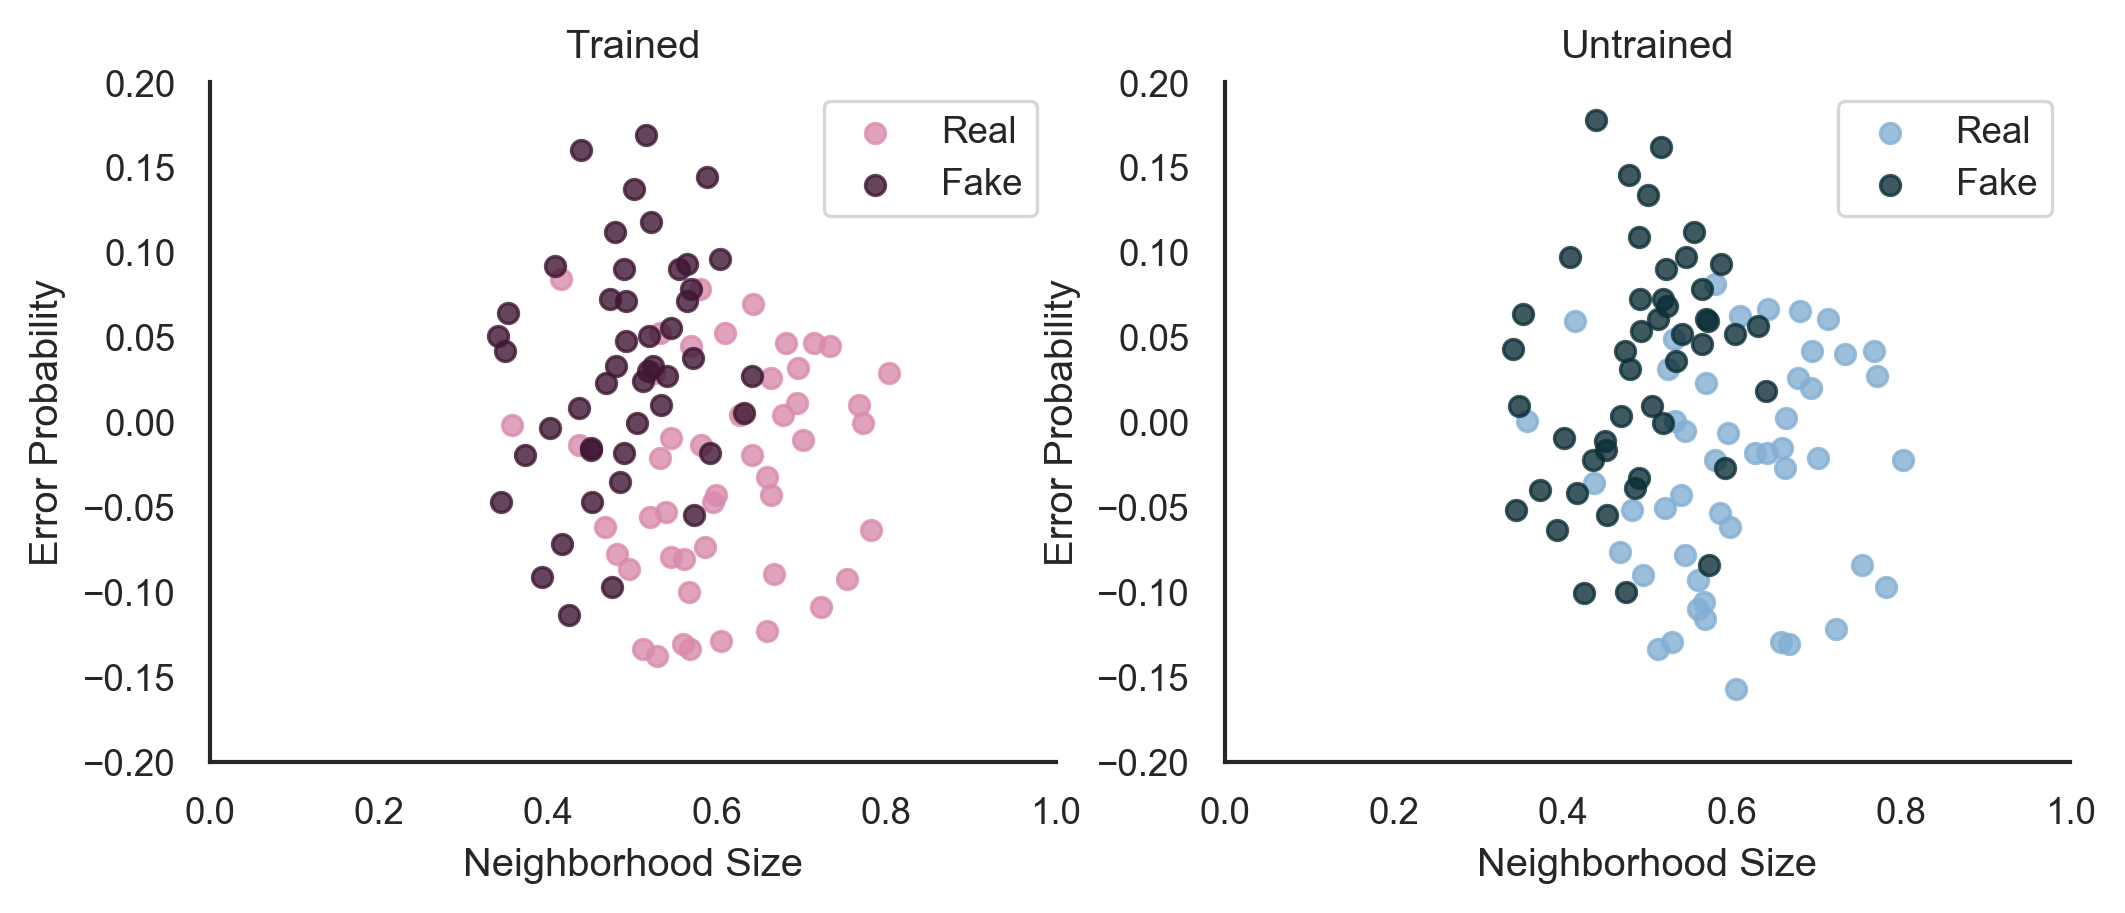

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3), dpi=300)

f_col = difficulties['Is Real'] == True

ax = axes[0]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[0], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Trained'] / 36, color=colors[1], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Trained')

ax = axes[1]

d = difficulties.loc[f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[2], label='Real', alpha=.8)

d = difficulties.loc[~f_col]
ax.scatter(d['neighborhood_size'], d['Untrained'] / 36, color=colors[3], label='Fake', alpha=.8)

ax.legend(loc=0)
plt.setp(ax, title='Untrained')

plt.setp(
    axes,
    xlim=[0, 1], xlabel='Neighborhood Size',
    ylim=[-.2, .2], ylabel='Error Probability'
)


sns.despine()

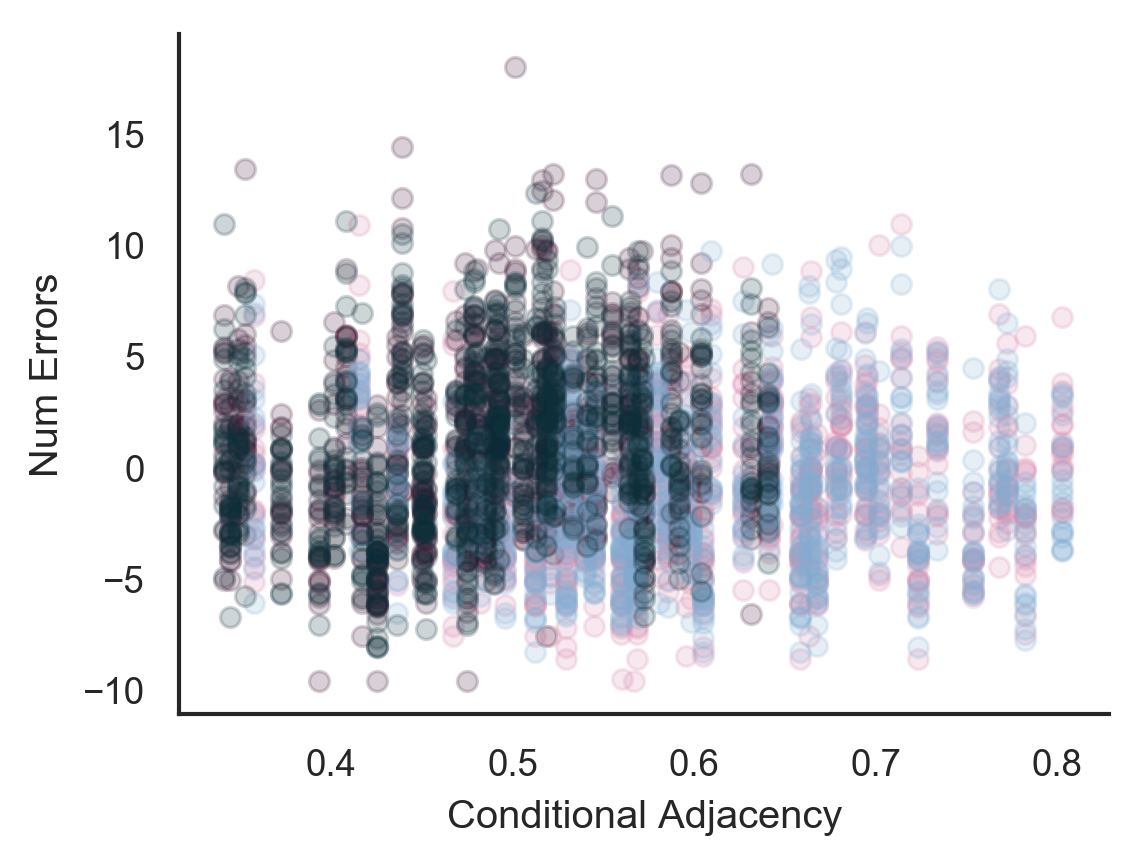

In [51]:
fig, axes = plt.subplots(1, 1, figsize=(4, 3), dpi=300)



ax = axes
x = tidy.loc[c&r, 'neighborhood_size']
y = tidy.loc[c&r, 'corrected_errors']
ax.scatter(x, y, color=colors[0], alpha=.2)
x = tidy.loc[c&~r, 'neighborhood_size']
y = tidy.loc[c&~r, 'corrected_errors']
ax.scatter(x, y, color=colors[1], alpha=.2)
x = tidy.loc[~c&r, 'neighborhood_size']
y = tidy.loc[~c&r, 'corrected_errors']
ax.scatter(x, y, color=colors[2], alpha=.2)
x = tidy.loc[~c&~r, 'neighborhood_size']
y = tidy.loc[~c&~r, 'corrected_errors']
ax.scatter(x, y, color=colors[3], alpha=.2)

plt.setp(axes, xlabel='Conditional Adjacency', ylabel='Num Errors')

sns.despine()